In [1]:
!pip install pyomo
!apt install -y glpk-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 18 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 k

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

## production Planning
An automobile assembly plant assembles two types of vehicles: a four-door saloon and a people carrier. Both vehicle types must pass through a painting plant and an assembly plant. If the painting plant only paints four-door saloons, it can paint some 2,000 vehicles each day, whereas if it paints only people carriers, it can paint some 1,500 vehicles each day. Moreover, if the assembly plant only assembles either four-door saloons or people carriers, it can assemble some 2,200 vehicles every day. Each people carrier implies an average profit of $3,000, whereas a fourdoor saloon implies an average profit of $2,100. maximise the vehicle assembly plant’s daily profit

In [3]:
#instatiate an object of ConcreteModel class
model = pyo.ConcreteModel()

# Sets
model.i = pyo.Set(initialize=range(1, 3))

# Parameters

# painting_parameter
model.pa = pyo.Param(model.i, initialize = {1:2000,2:1500})
pa = model.pa

# assembly_parameter
model.a = pyo.Param(model.i, initialize = {1:2200,2:2200})
a = model.a

#profit_parameter
model.p = pyo.Param(model.i, initialize = {1:2100,2:3000})
p = model.p

# Decision Variables

model.x = pyo.Var(model.i, within=pyo.NonNegativeReals)
x= model.x


#Objective Function
def daily_profit(model):
    return sum(p[i] * x[i] for i in model.i)


model.obj = pyo.Objective(rule=daily_profit, sense=pyo.maximize)

# Constraints
def painting_constraint(model,i):
    """fraction of painting for each car type must be less than or equal to 1

    Args:
        model (_type_): _description_
        i (_type_): _description_
    """
    return sum((1/pa[i])*x[i] for i in model.i) <= 1

def assembly_constraint(model,i):
    """fraction of assembly for each car type must be less than or equal to 1

    Args:
        model (_type_): _description_
        i (_type_): _description_
    """
    return sum((1/a[i])*x[i] for i in model.i) <= 1

model.const1 = pyo.Constraint(model.i, rule=painting_constraint)
model.const2 = pyo.Constraint(model.i, rule=assembly_constraint)

# Solve the model

solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the results
print(results)
print("PROFIT = ",model.obj())
for i in model.i:
    print("value of ", i," =",x[i]() )



Problem: 
- Name: unknown
  Lower bound: 4500000.0
  Upper bound: 4500000.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 8
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.004662990570068359
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

PROFIT =  4500000.0
value of  1  = 0.0
value of  2  = 1500.0


## Portfolio Manager

ORGASA has a portfolio of investments in shares, bonds and other investment alternatives. Now it has available funds amounting to $200,000 which must be considered for new investments. The four investment alternatives that ORGASA is contemplating are offered in Table
The measure of risk indicates uncertainty associated with the share in terms of its capacity to reach the annual return foreseen; the higher the value, the greater the risk. ORGASA has stipulated the following conditions for its investment:

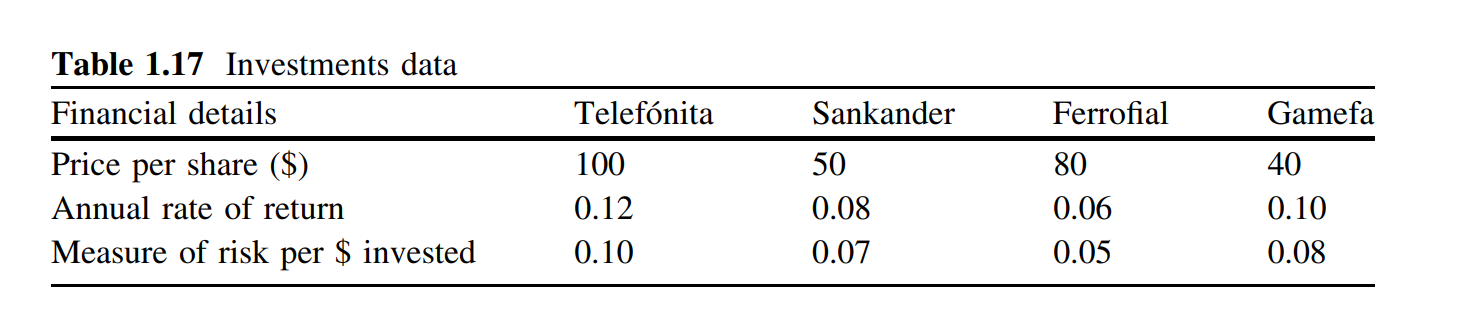


• Rule 1: The annual rate of return from this portfolio must be at least 9 %.
• Rule 2: No value can represent more than 50 % of the total investment in dollars.

(a) Use the linear programming model to develop a portfolio of investments which minimises the risk.
(b) If the firm ignores the risk involved and uses a maximum return strategy on its investment, how will the former model be amended

In [4]:
#instatiate the model from ConcretModel
model = pyo.ConcreteModel()

# Set
model.i = pyo.Set(initialize = range(1,5))


# Parameters
model.p = pyo.Param(model.i, initialize = {1:100,2:50,3:80,4:40})
p = model.p # price per share

model.ar = pyo.Param(model.i, initialize ={1:0.12,2:0.08,3:0.06,4:0.1})
ar = model.ar # annual rate of return

model.r = pyo.Param(model.i, initialize ={1:0.1,2:0.07,3:0.05,4:0.08})
r = model.r # measure of risk on per dollar of invested



# Variables

def bounds(model,i):
    lb ={}
    ub = {}
    for i in model.i:
        lb[i] = 0
        ub[i] = 200000*0.5/p[i]
    return (lb[i],ub[i])

model.x = pyo.Var(model.i, within = pyo.NonNegativeReals, bounds=bounds)
x=  model.x

# objective function
def minimize_risk(model):
    return sum(r[i]*p[i]*x[i] for i in model.i)

model.obj2 = pyo.Objective(rule = minimize_risk, sense = pyo.minimize)

# Constraints

def aror_constraint(model,i):
    # annual rate of return constraint atleast 9%
    return sum(ar[i]*p[i]*x[i] for i in model.i) >= 200000 *0.09

model.const1 = pyo.Constraint(model.i, rule = aror_constraint)


## either use below code or use the bounds
# def constr2(model,i):
#     return p[1]*x[1]<=200000 *0.5

# model.const2 = pyo.Constraint(model.i, rule = constr2)
# def constr3(model,i):
#     return p[2]*x[2]<=200000 *0.5

# model.const3 = pyo.Constraint(model.i, rule = constr3)

# def constr4(model,i):
#     return p[3]*x[3]<=200000 *0.5

# model.const4 = pyo.Constraint(model.i, rule = constr4)
# def constr5(model,i):
#     return p[4]*x[4]<=200000 *0.5

# model.const5 = pyo.Constraint(model.i, rule = constr5)

def equality_investment(model,i):
    return sum(p[i]*x[i] for i in model.i) == 200000

model.const6 = pyo.Constraint(model.i, rule = equality_investment)

# Solve the model


solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the results
print(results)
print("PROFIT = ",model.obj2())
for i in model.i:
    print("value of ", i," =",x[i]() )



Problem: 
- Name: unknown
  Lower bound: 14666.6666666667
  Upper bound: 14666.6666666667
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 4
  Number of nonzeros: 32
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.004713296890258789
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

PROFIT =  14666.666666666662
value of  1  = 333.333333333333
value of  2  = 0.0
value of  3  = 833.333333333333
value of  4  = 2500.0


In [5]:
#instatiate the model from ConcretModel
model = pyo.ConcreteModel()

# Set
model.i = pyo.Set(initialize = range(1,5))


# Parameters
model.p = pyo.Param(model.i, initialize = {1:100,2:50,3:80,4:40})
p = model.p # price per share

model.ar = pyo.Param(model.i, initialize ={1:0.12,2:0.08,3:0.06,4:0.1})
ar = model.ar # annual rate of return

model.r = pyo.Param(model.i, initialize ={1:0.1,2:0.07,3:0.05,4:0.08})
r = model.r # measure of risk on per dollar of invested



# Variables

def bounds(model,i):
    lb ={}
    ub = {}
    for i in model.i:
        lb[i] = 0
        ub[i] = 200000*0.5/p[i]
    return (lb[i],ub[i])

model.x = pyo.Var(model.i, within = pyo.NonNegativeReals, bounds=bounds)
x=  model.x

# objective function
def maximize_profit(model):
    return sum(r[i]*p[i]*x[i] for i in model.i)

model.obj2 = pyo.Objective(rule = maximize_profit, sense = pyo.maximize)

# Constraints

def aror_constraint(model,i):
    # annual rate of return constraint atleast 9%
    return sum(ar[i]*p[i]*x[i] for i in model.i) >= 200000 *0.09

model.const1 = pyo.Constraint(model.i, rule = aror_constraint)


## either use below code or use the bounds
# def constr2(model,i):
#     return p[1]*x[1]<=200000 *0.5

# model.const2 = pyo.Constraint(model.i, rule = constr2)
# def constr3(model,i):
#     return p[2]*x[2]<=200000 *0.5

# model.const3 = pyo.Constraint(model.i, rule = constr3)

# def constr4(model,i):
#     return p[3]*x[3]<=200000 *0.5

# model.const4 = pyo.Constraint(model.i, rule = constr4)
# def constr5(model,i):
#     return p[4]*x[4]<=200000 *0.5

# model.const5 = pyo.Constraint(model.i, rule = constr5)

def equality_investment(model,i):
    return sum(p[i]*x[i] for i in model.i) == 200000

model.const6 = pyo.Constraint(model.i, rule = equality_investment)

# Solve the model


solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the results
print(results)
print("PROFIT = ",model.obj2())
for i in model.i:
    print("value of ", i," =",x[i]() )



Problem: 
- Name: unknown
  Lower bound: 20000.0
  Upper bound: 20000.0
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 4
  Number of nonzeros: 32
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.006572723388671875
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

PROFIT =  20000.0
value of  1  = 2000.0
value of  2  = 0.0
value of  3  = 0.0
value of  4  = 0.0


### Bonuses & Merits

The Campus Social Board in New York budgeted $1,500,000 as the bonuses and
merits of 503 university teachers. A Salary Differential Evaluation Board, comprising Campus Social Board members, administrators, supervisors and teachers,
determined the three variables that should affect bonuses and merits. If we name
these variables as CM1, CM2 and CM3, we obtain:
CM1: Teachers’ performance measured by the university evaluation instrument.
CM2: General services to the university and its students, including voluntary
activities, etc.
CM3: Professional development, measured by a formula, which includes teaching
merits, research, participation in management tasks, etc.
All three variables above are measured on a scale ranging from 1 (low) to 5
(high). The points scored during 1 year determine bonuses and merits for the
following year. In 2001, the sum of the points of these variables was:

CM1 = 1,625

CM2 = 1,409

CM3 = 1,387

The Evaluation Board recommended, and the Campus Social Board accepted,
the following rules:

• Rule 1: No teacher should receive more than $5,000 for bonuses and merits in
any given year.

• Rule 2: One CM1 variable point is worth twice a CM2 variable point; one CM1
variable point is worth twice a CM3 variable point.

• Rule 3: The value of one of the CM1, CM2, CM3 variable points should be as
high as possible, but subject to the total budget and to these rules.

In [6]:
#instatiate the model from ConcretModel
model = pyo.ConcreteModel()

# Set
model.i = pyo.Set(initialize = range(1,4))


# Parameters
model.p = pyo.Param(model.i, initialize = {1:5,2:5,3:5})
p = model.p # Max points

model.cm = pyo.Param(model.i, initialize ={1:1625,2:1409,3:1387})
cm = model.cm # total points of cm

model.eq = pyo.Param(model.i, initialize ={1:1,2:-1,3:-1})
eq = model.eq # equality params

# Variables

model.x = pyo.Var(model.i, within = pyo.NonNegativeReals )
x =  model.x


# Objective Function
def maximize_value(model):
  return sum(x[i] for i in model.i)

model.objF = pyo.Objective(rule = maximize_value, sense = pyo.maximize)

# constraints

# bonus & merit constraint
def constr1(mode,i):
  return sum(p[i]*x[i] for i in model.i)<=5000

model.const1 = pyo.Constraint(model.i, rule = constr1)

# max budget constraint
def constr2(mode,i):
  return sum(cm[i]*x[i] for i in model.i)<=1500000

model.const2 = pyo.Constraint(model.i, rule = constr2)

# x1= 2x3,  x1= 2x2 hence
def constr3(model,i):
  return sum(eq[i]*x[i]  for i in model.i)==0
model.const3 = pyo.Constraint(model.i, rule = constr3)


# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the results
print(results)
print("value = ",model.objF())
for i in model.i:
    print("value of ", i," =",x[i]() )



Problem: 
- Name: unknown
  Lower bound: 996.01593625498
  Upper bound: 996.01593625498
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 3
  Number of nonzeros: 27
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.00783991813659668
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

value =  996.01593625498
value of  1  = 498.00796812749
value of  2  = 0.0
value of  3  = 498.00796812749



##  Renting Warehouses

A firm has realised that it will not have sufficient storage space for the next three
months. Details of the additional storage requirements for the next 3 months are
provided in Table 1.18.
To cover its requirements, the firm plans to rent additional space on a short term basis. At the beginning of each month, the firm can rent any amount of space
for any number of months. It can pay separate rents of different quantities of space
and/or over different periods of time. For instance, during the first month it could
rent 20,000 m2 for 2 months, and rent 5,000 m2 separately for 1 month. It could
also acquire new rented spaces before the previous ones expire. The costs per
1,000 m2 of rented space in accordance with duration are provided in Table 1.19.
Build a linear programming model whose solution provides a rent policy that
covers space requirements at a minimum cost

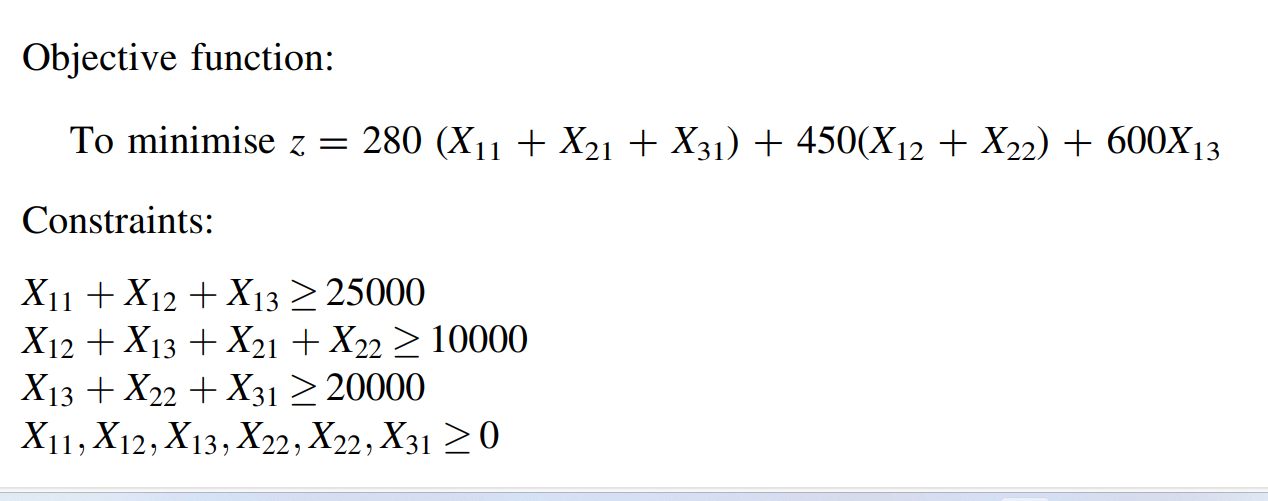

## Production Planning in a Tubes Factory

A steel tubes factory produces three sizes of tubes: small (1), medium (2) and large
(3). These tubes can be produced in any of three machines: A, B or C. Each unit of
product 1 requires 3 h in machine A, 2 h in machine B and 1 h in machine C. Each
unit of product 2 requires 4 h in machine A, 1 h in machine B and 3 h in machine
C. Each unit of product 3 requires 2 h in machine A, 2 h in machine B and 2 h in
machine C. Profit is $30
for product 1, $40 for product 2 and $35 for product 3.
Machine A can be used for a maximum of 90 h, machine B for a maximum of 54 h
and machine C for a maximum of 93 h. What would the minimum profit be for product 1 for its production to be
profitable?

## Production Planning of a Wires Manufacturer

A firm in Valencia manufactures aluminium and copper wires. Each kg of aluminium wire requires 5 kWh of electricity and 0.25 h of labour. Each kg of copper
wire requires 2 kWh of electricity and 0.5 h of labour. Copper wire production
would be restricted by the fact that the quantity of raw materials available permits
the maximum production of 60 kg/day. Electricity is limited to 500 kWh/day and
labour to 40 h/day. The aluminium wire profit is $0.25/kg, while the copper wire
profit is $0.4/kg. What quantity of each wire should be produced to maximise the
profit and what would the profit be?

In [8]:
import numpy as np
#instatiate the model from ConcretModel
model = pyo.ConcreteModel()

# Set
model.i = pyo.Set(initialize = ["Aluminum","Copper"])

# Parameters
model.p = pyo.Param(model.i, initialize = {"Aluminum":0.25,"Copper":0.4})
p = model.p # profit per kg

model.e = pyo.Param(model.i, initialize = {"Aluminum":5,"Copper":2})
e = model.e # Electricity limit

model.l = pyo.Param(model.i, initialize = {"Aluminum":0.25,"Copper":0.5})
l = model.l # labour limit

# Variables
lb  = { "Aluminum":0 ,"Copper":0}
ub  = { "Aluminum":np.inf ,"Copper":60}

def bounds(model,i):
  return (lb[i],ub[i])

model.x = pyo.Var(model.i, within = pyo.NonNegativeReals, bounds=bounds )
x =  model.x


# Objective Function
def maximize_value(model):
  return sum(p[i]*x[i] for i in model.i)

model.objF = pyo.Objective(rule = maximize_value, sense = pyo.maximize)

# constraints

# electricity constraint
def constr1(mode,i):
  return sum(e[i]*x[i] for i in model.i)<=500

model.const1 = pyo.Constraint(model.i, rule = constr1)

# labour constraint
def constr2(mode,i):
  return sum(l[i]*x[i] for i in model.i)<=40

model.const2 = pyo.Constraint(model.i, rule = constr2)


# Solve the model
solver = SolverFactory('glpk')
results = solver.solve(model)

# Print the results
print(results)
print("value = ",model.objF())
for i in model.i:
    print("value of ", i," =",x[i]() )




Problem: 
- Name: unknown
  Lower bound: 36.25
  Upper bound: 36.25
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 8
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.023675918579101562
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

value =  36.25
value of  Aluminum  = 85.0
value of  Copper  = 37.5


## Mixed Investments

The firm Inversiones Internacionales, S.A.U. has up to 5 million $ available to
invest in six possible investments. Table 1.21 shows the characteristics of each
investment.
From experience in such investments, the firm knows it is not recommended to
invest more than 25 % of the total investment in any of these investment options.
Besides, it is necessary to invest at least 30 % in precious metals, and at least 45 %
between trade credits and corporate bonds. Finally, an overall risk limit of no more
than 2.0 is required. Build a linear programming model whose solution indicates how much the firm
should invest in all six possible investment options to maximise the profitability of
its investments.

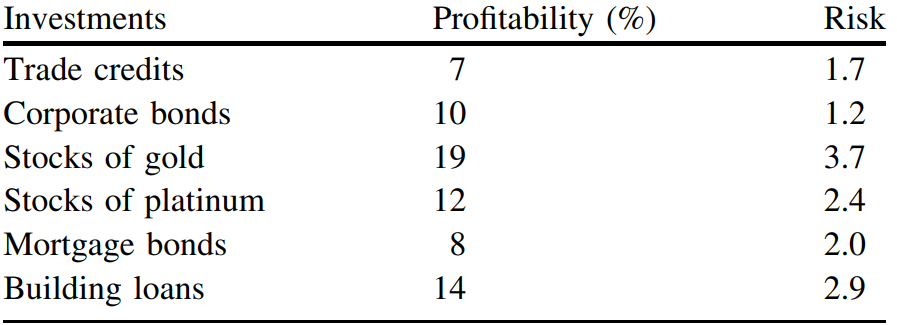